In [1]:
from tensorflow.keras.applications import ResNet50

# load the Resnet50 network *pre-trained* on the ImageNet dataset
model = ResNet50(weights="imagenet")

model.summary()

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def show_image(image_path):
    image = mpimg.imread(image_path)
    print(image.shape)
    plt.imshow(image)


102967424/102967424 [==============================] - 4s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                    

In [2]:
import zipfile

# 1) 압축 풀기
local_zip = '/content/raccoon_dog_raccoon.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content')
zip_ref.close()



(168, 300, 3)


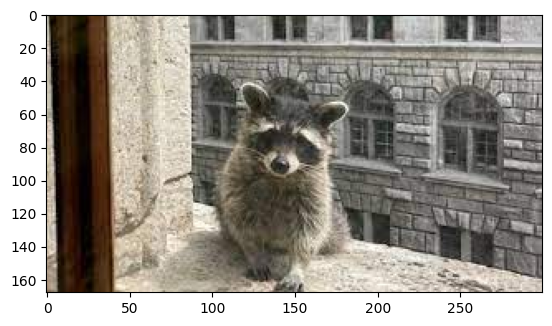

In [3]:
show_image("/content/raccoon_dog_raccoon/raccoon/raccoon_1.jpg")

In [4]:
from tensorflow.keras.preprocessing import image as image_utils
from tensorflow.keras.applications.resnet50 import preprocess_input

def load_and_process_image(image_path):
    # Print image's original shape, for reference
    print('Original image shape: ', mpimg.imread(image_path).shape)

    # Load in the image with a target size of 224, 224
    image = image_utils.load_img(image_path, target_size=(224, 224))
    # Convert the image from a PIL format to a numpy array
    image = image_utils.img_to_array(image)
    # Add a dimension for number of images, in our case 1
    image = image.reshape(1,224,224,3)
    # Preprocess image to align with original ImageNet dataset
    image = preprocess_input(image)
    # Print image's shape after processing
    print('Processed image shape: ', image.shape)
    return image

In [5]:
processed_image = load_and_process_image('/content/raccoon_dog_raccoon/raccoon/raccoon_1.jpg')

Original image shape:  (168, 300, 3)
Processed image shape:  (1, 224, 224, 3)


In [6]:
from tensorflow.keras.applications.resnet50 import decode_predictions

def readable_prediction(image_path):
    # Show image
    show_image(image_path)
    # Load and pre-process image
    image = load_and_process_image(image_path)
    # Make predictions
    predictions = model.predict(image)
    # Print predictions in readable form
    print('Predicted:', decode_predictions(predictions, top=3))


(168, 300, 3)
Original image shape:  (168, 300, 3)
Processed image shape:  (1, 224, 224, 3)
35363/35363 [==============================] - 0s 0us/step
Predicted: [[('n02325366', 'wood_rabbit', 0.5549876), ('n02326432', 'hare', 0.28799903), ('n02437616', 'llama', 0.05855945)]]


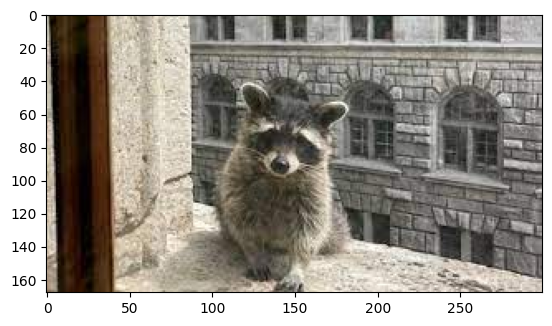

In [7]:
readable_prediction("/content/raccoon_dog_raccoon/raccoon/raccoon_1.jpg")

In [8]:
from tensorflow import keras

base_model = keras.applications.ResNet50(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(224, 224, 3),
    include_top=False)

94765736/94765736 [==============================] - 3s 0us/step


In [9]:
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_2[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                       

In [10]:
base_model.trainable = False

In [11]:
inputs = keras.Input(shape=(224, 224, 3))
# Separately from setting trainable on the model, we set training to False
x = base_model(inputs, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
# A Dense classifier with a single unit (binary classification)
outputs = keras.layers.Dense(1)(x)
model = keras.Model(inputs, outputs)


In [12]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 1)                 2049      
                                                                 
Total params: 23589761 (89.99 MB)
Trainable params: 2049 (8.00 KB)
Non-trainable params: 23587712 (89.98 MB)
_________________________________________________________________


In [13]:
# Important to use binary crossentropy and binary accuracy as we now have a binary classification problem
model.compile(loss=keras.losses.BinaryCrossentropy(from_logits=True), metrics=[keras.metrics.BinaryAccuracy()])


In [14]:
import os
import shutil
import random

# 데이터셋 디렉토리
dataset_dir = '/content/raccoon_dog_raccoon'

# 훈련 데이터와 검증 데이터를 저장할 디렉토리 생성
train_dir = '/content/train_data/'
validation_dir = '/content/validation_data/'
os.makedirs(train_dir, exist_ok=True)
os.makedirs(validation_dir, exist_ok=True)

# 클래스 목록
classes = ['raccoon', 'raccoon_dog']

# 훈련 데이터와 검증 데이터 비율 설정
train_ratio = 0.9  # 훈련 데이터 비율
validation_ratio = 0.1  # 검증 데이터 비율
random.seed(777) #랜덤시드고정

# 각 클래스에 대해 훈련과 검증 데이터로 나누기
for class_name in classes:
    class_path = os.path.join(dataset_dir, class_name)
    images = os.listdir(class_path)
    random.shuffle(images)  # 이미지 섞기

    # 이미지 개수 계산
    total_images = len(images)
    train_size = int(total_images * train_ratio)

    # 훈련 데이터 복사
    for image in images[:train_size]:
        src_path = os.path.join(class_path, image)
        dest_path = os.path.join(train_dir, class_name, image)
        os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
        shutil.copy(src_path, dest_path)

    # 검증 데이터 복사
    for image in images[train_size:]:
        src_path = os.path.join(class_path, image)
        dest_path = os.path.join(validation_dir, class_name, image)
        os.makedirs(os.path.join(validation_dir, class_name), exist_ok=True)
        shutil.copy(src_path, dest_path)

print("데이터 분리 완료.")

데이터 분리 완료.


In [15]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# create a data generator
datagen = ImageDataGenerator(
        samplewise_center=True,  # set each sample mean to 0
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False) # we don't expect Bo to be upside-down so we will not flip vertically


In [16]:
# load and iterate training dataset
train_it = datagen.flow_from_directory('/content/train_data',
                                       target_size=(224, 224),
                                       color_mode='rgb',
                                       class_mode='binary',
                                       batch_size=8)
# load and iterate validation dataset
valid_it = datagen.flow_from_directory('/content/validation_data',
                                      target_size=(224, 224),
                                      color_mode='rgb',
                                      class_mode='binary',
                                      batch_size=8)

Found 400 images belonging to 2 classes.
Found 46 images belonging to 2 classes.


In [17]:
model.fit(train_it, steps_per_epoch=12, validation_data=valid_it, validation_steps=4, epochs=50)

Epoch 1/50
12/12 [==============================] - 9s 282ms/step - loss: 0.6403 - binary_accuracy: 0.6667 - val_loss: 0.6232 - val_binary_accuracy: 0.6562
Epoch 2/50
12/12 [==============================] - 3s 235ms/step - loss: 0.5764 - binary_accuracy: 0.6875 - val_loss: 0.5757 - val_binary_accuracy: 0.6875
Epoch 3/50
12/12 [==============================] - 3s 236ms/step - loss: 0.4335 - binary_accuracy: 0.8438 - val_loss: 0.4796 - val_binary_accuracy: 0.7812
Epoch 4/50
12/12 [==============================] - 2s 187ms/step - loss: 0.3695 - binary_accuracy: 0.8333 - val_loss: 0.5589 - val_binary_accuracy: 0.8438
Epoch 5/50
12/12 [==============================] - 3s 280ms/step - loss: 0.3355 - binary_accuracy: 0.8854 - val_loss: 0.4023 - val_binary_accuracy: 0.7812
Epoch 6/50
12/12 [==============================] - 2s 187ms/step - loss: 0.2892 - binary_accuracy: 0.8646 - val_loss: 0.5179 - val_binary_accuracy: 0.7500
Epoch 7/50
12/12 [==============================] - 3s 237ms/ste

In [18]:
# Unfreeze the base model
base_model.trainable = True

# It's important to recompile your model after you make any changes
# to the `trainable` attribute of any inner layer, so that your changes
# are taken into account
model.compile(optimizer=keras.optimizers.RMSprop(learning_rate = .00001),  # Very low learning rate
              loss=keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=[keras.metrics.BinaryAccuracy()])

In [19]:
history = model.fit(train_it, steps_per_epoch=12, validation_data=valid_it, validation_steps=4, epochs=20)

Epoch 1/20
12/12 [==============================] - 28s 314ms/step - loss: 0.2021 - binary_accuracy: 0.9479 - val_loss: 0.0809 - val_binary_accuracy: 1.0000
Epoch 2/20
12/12 [==============================] - 3s 208ms/step - loss: 0.1112 - binary_accuracy: 0.9688 - val_loss: 0.4380 - val_binary_accuracy: 0.9062
Epoch 3/20
12/12 [==============================] - 3s 237ms/step - loss: 0.0888 - binary_accuracy: 0.9792 - val_loss: 0.2594 - val_binary_accuracy: 0.9375
Epoch 4/20
12/12 [==============================] - 2s 203ms/step - loss: 0.0916 - binary_accuracy: 0.9688 - val_loss: 0.4555 - val_binary_accuracy: 0.9062
Epoch 5/20
12/12 [==============================] - 2s 206ms/step - loss: 0.1175 - binary_accuracy: 0.9479 - val_loss: 0.4557 - val_binary_accuracy: 0.8438
Epoch 6/20
12/12 [==============================] - 3s 257ms/step - loss: 0.0817 - binary_accuracy: 0.9583 - val_loss: 0.3554 - val_binary_accuracy: 0.8750
Epoch 7/20
12/12 [==============================] - 3s 266ms/st

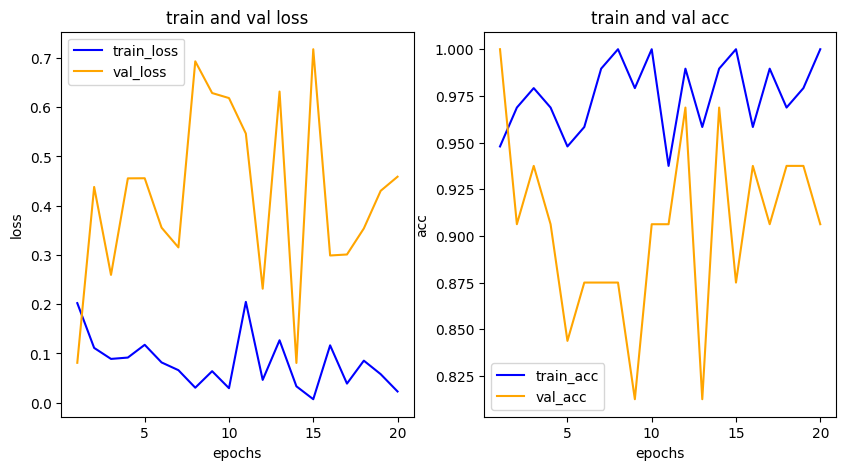

In [20]:
import matplotlib.pyplot as plt

his_dict = history.history
loss = his_dict['loss']
val_loss = his_dict['val_loss']

epochs = range(1, len(loss) + 1)
fig = plt.figure(figsize = (10, 5))

# 훈련 및 검증 손실 그리기
ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(epochs, loss, color = 'blue', label = 'train_loss')
ax1.plot(epochs, val_loss, color = 'orange', label = 'val_loss')
ax1.set_title('train and val loss')
ax1.set_xlabel('epochs')
ax1.set_ylabel('loss')
ax1.legend()

acc = his_dict['binary_accuracy']
val_acc = his_dict['val_binary_accuracy']

# 훈련 및 검증 정확도 그리기
ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(epochs, acc, color = 'blue', label = 'train_acc')
ax2.plot(epochs, val_acc, color = 'orange', label = 'val_acc')
ax2.set_title('train and val acc')
ax2.set_xlabel('epochs')
ax2.set_ylabel('acc')
ax2.legend()

plt.show()

# 모델 평가



In [21]:
model.evaluate_generator(valid_it)

<ipython-input-21-fdc6348bc2ac>:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  model.evaluate_generator(valid_it)


[0.5085605382919312, 0.9130434989929199]

In [22]:
model.evaluate_generator(train_it)

<ipython-input-22-d2ac2afd28c5>:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  model.evaluate_generator(train_it)


[0.025043301284313202, 0.9900000095367432]

In [23]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow.keras.preprocessing import image as image_utils
from tensorflow.keras.applications.imagenet_utils import preprocess_input

def show_image(image_path):
    image = mpimg.imread(image_path)
    plt.imshow(image)

def make_predictions(image_path):
    show_image(image_path)
    image = image_utils.load_img(image_path, target_size=(224, 224))
    image = image_utils.img_to_array(image)
    image = image.reshape(1,224,224,3)
    image = preprocess_input(image)
    preds = model.predict(image)
    return preds

1/1 [==============================] - 1s 944ms/step


array([[-5.187268]], dtype=float32)

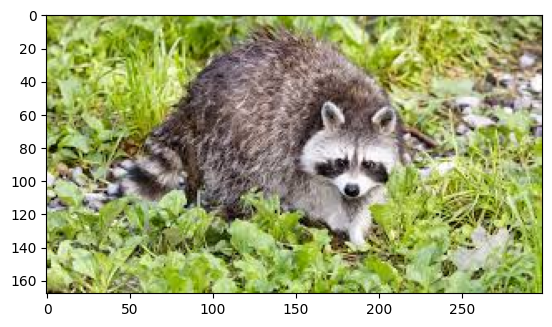

In [24]:
make_predictions('/content/raccoon_dog_raccoon/raccoon/raccoon_101.jpg')

1/1 [==============================] - 0s 38ms/step


array([[3.0108192]], dtype=float32)

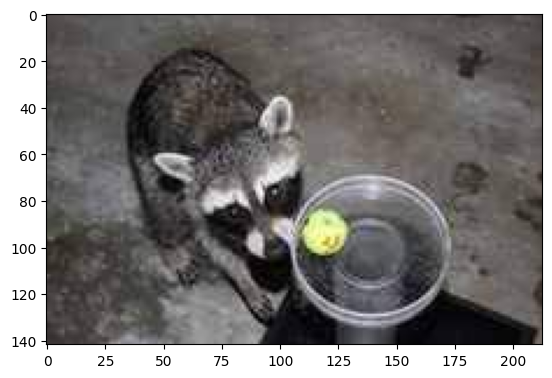

In [25]:
make_predictions('/content/raccoon_dog_raccoon/raccoon_dog/raccoon_dog_115.jpg')

In [26]:
def raccoon(image_path):
    preds = make_predictions(image_path)
    if preds[0] < 0:
        print("It's raccoon! alien species!")
    else:
        print("It's raccoon_dog!, korean species!")

1/1 [==============================] - 0s 24ms/step
It's raccoon! alien species!


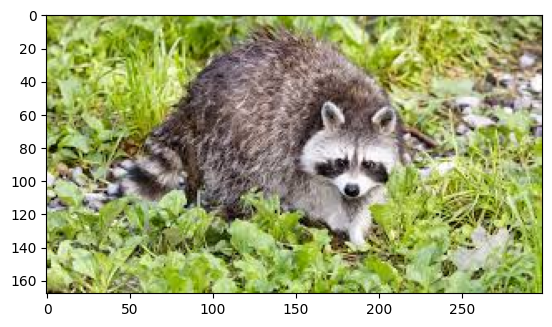

In [27]:
# 예측할 이미지 경로
new_image_path = '/content/raccoon_dog_raccoon/raccoon/raccoon_101.jpg'

# 새로운 이미지에 대한 예측 수행
raccoon(new_image_path)

1/1 [==============================] - 0s 25ms/step
It's raccoon_dog!, korean species!


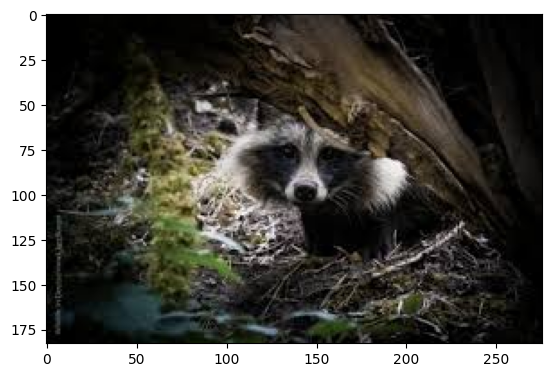

In [28]:
# 예측할 이미지 경로
new_image_path = '/content/raccoon_dog_raccoon/raccoon_dog/raccoon_dog_118.jpg'

# 새로운 이미지에 대한 예측 수행
raccoon(new_image_path)

In [29]:
model.save('/content/resnet_model.keras')